# Eminente HW 4: AUTOENCODERS


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import csv
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
from time import time
from sklearn.model_selection import KFold
from sklearn import manifold

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import warnings
warnings.filterwarnings("ignore")

torch.seed(614)

In [ ]:
# GPU
usingCuda = False
if torch.cuda.is_available():
  usingCuda = True
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
print('Using Cuda:', usingCuda)

Using Cuda: True


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/DeepLearning/HW4/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Autoencoder class

In [ ]:
class Autoencoder(nn.Module):
    
    def __init__(self, encoded_space_dim, dropout):
        super().__init__()

        self.encoded_space_dim=encoded_space_dim
        self.dropout=dropout

        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(self.dropout),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(self.dropout),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout(self.dropout)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Dropout(self.dropout),
            nn.Linear(64, self.encoded_space_dim)
        )

        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(self.encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Dropout(self.dropout),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Dropout(self.dropout)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout(self.dropout),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout(self.dropout),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

    def train_epoch(self, dataloader, loss_fn, optimizer):
        # Training
        self.train()
        loss_log = []
        for train_batch in dataloader:
            image_batch = train_batch[0].to(device) 
            #Forward
            output = self(image_batch)
            loss = loss_fn(output, image_batch)
            # Backward 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.data.cpu().numpy())
        loss_log = np.asarray(loss_log)
        return np.mean(loss_log)

    def train_epoch_mod(self, dataloader, loss_fn, optimizer):
        # Training
        self.train()
        loss_log = []
        for train_batch in dataloader:
            mod_batch = train_batch[1].to(device)
            image_batch = train_batch[0].to(device)
            #Forward
            output = self(mod_batch)
            loss = loss_fn(output, image_batch)
            # Backward 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.data.cpu().numpy())
        loss_log = np.asarray(loss_log)
        return np.mean(loss_log)

    def test_epoch(self, dataloader, loss_fn, additional_out=False):
        # Validation
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # No need to track the gradients
            conc_out = torch.Tensor().float()
            conc_label = torch.Tensor().float()
            for sample_batch in dataloader:
                # Extract data and move tensors to the selected device
                image_batch = sample_batch[0].to(device)
                # Forward pass
                out = net(image_batch)
                # Concatenate with previous outputs
                conc_out = torch.cat([conc_out, out])
                conc_label = torch.cat([conc_label, image_batch]) 
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
            if additional_out:
                return val_loss.data.cpu().numpy(), conc_out.cpu().numpy(), conc_label.cpu().numpy()
            else:
                return val_loss.data.cpu().numpy()

    def test_epoch_mod(self, dataloader, loss_fn, additional_out=False):
        # Validation
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # No need to track the gradients
            conc_out = torch.Tensor().float()
            conc_label = torch.Tensor().float()
            for sample_batch in dataloader:
                # Extract data and move tensors to the selected device
                mod_batch = sample_batch[1].to(device)
                image_batch = sample_batch[0].to(device)  #! train_batch[0]=img x 512, train_batch[1]=noised_img x 512, train_batch[2]=label x 512
                # Forward pass
                out = net(mod_batch)
                # Concatenate with previous outputs
                conc_out = torch.cat([conc_out, out])
                conc_label = torch.cat([conc_label, image_batch]) 
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
            if additional_out:
                return val_loss.data.cpu().numpy(), conc_out.cpu().numpy(), conc_label.cpu().numpy()
            else:
                return val_loss.data.cpu().numpy()

            
    def train_full(self, epochs, patience, train_dataloader, val_dataloader, loss_fn, optimizer, verbose, denoise=False):
        val_loss_best = float(1000)
        train_loss_log=[]
        val_loss_log=[]
        for epoch in range(epochs):

            start=time()

            if denoise:
                train_loss = self.train_epoch_mod(dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim) 
                val_loss = self.test_epoch_mod(dataloader=val_dataloader, loss_fn=loss_fn) 
            else:
                train_loss = self.train_epoch(dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim) 
                val_loss = self.test_epoch(dataloader=val_dataloader, loss_fn=loss_fn) 

            end = time()

            #Print Validationloss

            if verbose:
                print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, epochs, val_loss))
                print("\n Time elapsed for one epoch:", end-start)

            if val_loss <= val_loss_best:
                # Save network parameters
                torch.save(self, path+'denoise_model_esd_'+str(int(encoded_space_dim))+'.torch')
                val_loss_best = val_loss
                waiting = 0
            else:
                waiting +=1

            #Early stopping
            if waiting >= patience and epoch > 20:
                return train_loss_log, val_loss_log
                print("Val loss has not improved for %d epochs ---> early stopping" %(patience))
                print("Best validation error was at epoch %d " %(epoch - patience))
                break

            train_loss_log.append(train_loss)
            val_loss_log.append(val_loss)
            
        return train_loss_log, val_loss_log


    def get_encoded(self, dataset, label_present=False):

        encoded_imgs = []
        labels = []

        for sample in tqdm(dataset):
            if label_present:
                img = sample[0].unsqueeze(0).to(device)
                label = sample[1]
            else: 
                img = sample.unsqueeze(0).to(device)

            # Encode image
            self.eval()
            with torch.no_grad():
                encoded_img  = self.encode(img)

            encoded_imgs.append(encoded_img.flatten().cpu().numpy())
            if label_present:
                labels.append(label)

        if label_present:
            return encoded_imgs, labels
        else: return encoded_imgs

    def get_decoded(self, encoded_sample, return_img=False, **kwargs):
        filename = kwargs.get('filename', None)
        self.eval()
        with torch.no_grad():
            encoded_torch = torch.tensor(encoded_sample).float().unsqueeze(0)
            img  = self.decode(encoded_torch)

        if return_img:
            plt.figure(figsize=(8,6))
            plt.imshow(img.squeeze().cpu().numpy(), cmap='gist_gray')
            plt.savefig(path+"img/"+filename)
            plt.show()
            plt.close()
        else:
            return img

    
    def encoded_space_walk(self, dataset, start, end, filename, steps=20):
        
        #prepare dataset for masking (done via numpy and separating img and labels)
        test_loader = DataLoader(dataset, batch_size=len(dataset),  shuffle=False)
        test_dataset_array = next(iter(test_loader))[0].numpy()
        test_dataset_labels = next(iter(test_loader))[1].numpy()

        centroids=[]

        l = [start,end]
        #select only imgs with given label, encode them and compute centroids for that label
        for label in l:
            mask = test_dataset_labels==label
            dataset_l = torch.tensor(test_dataset_array[mask])
            encoded_dataset_l = net.get_encoded(dataset_l, label_present=False)
            centroids.append(np.array(encoded_dataset_l).mean(axis=0))

        trajectory=[]
        #create trajectory from one centroid to another
        for dim in range(self.encoded_space_dim):
            trajectory.append( np.linspace(centroids[0][dim], centroids[1][dim], steps) )

        #each row is an encoded representation, we have as many rows as the steps we are taking from start to end
        trajectory_samples=np.array(trajectory).transpose()#.reshape((-1,self.encoded_space_dim))

        #decode and plot
        cols=int(steps/2)
        fig, axs = plt.subplots(2, cols, figsize=(15,5))
        i=0
        for sample,ax in zip(trajectory_samples, axs.flatten()):
            #decode
            img = net.get_decoded(sample)
            #plot
            ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
            ax.set_title('step: %d' %i)
            ax.set_xticks([])
            ax.set_yticks([])
            i+=1
        fig.tight_layout()
        fig.savefig(path+"img/"+filename)
        plt.show()


    


### Functions for damaging data

In [ ]:
def add_Gaussian_noise(img, mean, std):
    shape = img.squeeze().shape
    noise = torch.empty(shape).normal_(mean=mean,std=std)
    return img.to(device) + noise.to(device)

def occlude(img, portion):
    shape = img.shape
    side = int(np.floor(np.sqrt(shape[1]*shape[2]*portion)))
    startx = np.random.randint(0,shape[1]-side)
    starty = np.random.randint(0,shape[2]-side)
    occlusion = torch.ones(shape)
    occlusion[0,startx:startx+side,starty:starty+side] = 0
    return img.to(device)*occlusion.to(device)

def modifier(choice, **kwargs):
    mean = kwargs.get('mean', None)
    std = kwargs.get('std', None)
    portion = kwargs.get('portion', None)
    if choice == None:
        return transforms.Compose([transforms.ToTensor()])
    elif choice == "noise":
        return transforms.Compose([transforms.ToTensor(),
                                   transforms.Lambda(lambda x: add_Gaussian_noise(x, mean, std))])
    elif choice == "occlude":
        return transforms.Compose([transforms.ToTensor(), 
                                   transforms.Lambda(lambda x: occlude(x, portion))])
        
def create_mod_dataset(original, mod):
    new_dataset=[]
    for i in range(len(original)):
        img = original[i][0]
        label = original[i][1]
        noised = mod[i][0]
        new_dataset.append((img, noised, label))
    return new_dataset


### Loading Dataset

Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw



Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw


Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw


Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw
Processing...
Done!
Data is of type: torchvision.datasets.mnist.MNIST
Train dataset has 60000 elements
Test dataset has 10000 elements





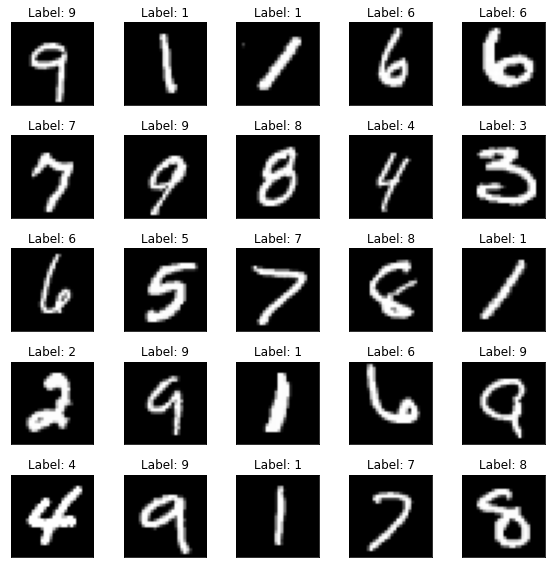

In [ ]:
#%% Define paths
data_root_dir = '../datasets'
#%% Create dataset
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)

print("Data is of type:", type(train_dataset))
print("Train dataset has %d elements" %(len(train_dataset)))
print("Test dataset has %d elements" %(len(test_dataset)))

### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()



# Random search

### First Training and plot

In [ ]:
### Training cycle
training = False
verbose = True


#--------FIXED PARAMETERS-------#
n_folds = 3
patience = 2
num_epochs = 60
encoded_space_dim = 4



#--------RANDOM SEARCH---------#
dropout = np.random.random()*(0.5) #uniform between 0 and 0.5
lr = 5*10**np.random.uniform(-4,-2)
L2decay = 5*10**np.random.uniform(-5,-3)

hyperpars={"encoded_space_dim":encoded_space_dim,
      "num_epochs": num_epochs,
      "patience":patience, 
      "nfolds":n_folds, 
      "dropout":dropout, 
      "lr": lr,
      "weight_decay":L2decay}


#reinitialize the network
net = Autoencoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2decay)
net.to(device)

### Define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

if training:
  #Train for #epochs with early stopping
  tl, vl = net.train_full(num_epochs, patience, train_dataloader, val_dataloader, loss_fn, optim, verbose)
else:
  print("Training flag is set to FALSE so no training was performed")


In [ ]:
plt.figure(figsize=(7,5))
plt.semilogy(tl, label='Train loss')
plt.semilogy(vl, label='Test loss')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()  

### Model selection via cross validation

In [ ]:
### Training cycle
training = False
verbose = False

if training:

  n_models=30 #!!!

  #--------FIXED PARAMETERS-------#
  n_folds = 3 #!!!
  patience = 6
  num_epochs = 45 #!!!
  encoded_space_dim = 4


  filename = path+"Models.csv"
  parameters=["encoded_space_dim", "num_epochs", "patience", 
              "nfolds", "dropout", "lr","weight_decay", "val_loss"]
  list_of_models = pd.DataFrame(columns=parameters)
  list_of_models.to_csv(filename,index=False)

  # Split and train
  kfolds = KFold(n_splits=n_folds,random_state=0, shuffle=True)
  kfolds.get_n_splits(train_dataset)



  for nm in tqdm(range(n_models)):#, desc="Models", leave=True):

    with open(filename,'a',newline='') as f:
      writer=csv.writer(f)

      #--------RANDOM SEARCH---------#
      dropout = np.random.random()*(0.5) #uniform between 0 and 0.5
      lr = 5*10**np.random.uniform(-4,-2)
      L2decay = 5*10**np.random.uniform(-5,-3)

      hyperpars={"encoded_space_dim":encoded_space_dim,
                "num_epochs": num_epochs,
                "patience":patience, 
                "nfolds":n_folds, 
                "dropout":dropout, 
                "lr": lr,
                "weight_decay":L2decay}

      #loop over folds
      CVlosses=[]
      cv_loop = 0

      for train_index, val_index in kfolds.split(train_dataset):

        print("\n\nTraining fold:", cv_loop)

        #reinitialize the network
        net = Autoencoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
        loss_fn = torch.nn.MSELoss()
        optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2decay)
        net.to(device)

        ###divide validation and training set
        train_set = torch.utils.data.Subset(train_dataset, train_index)
        val_set = torch.utils.data.Subset(train_dataset, val_index)
        ### Define dataloader
        train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True)
        val_dataloader = DataLoader(val_set, batch_size=512, shuffle=False)

        
        #Train for #epochs with early stopping
        tl, vl = net.train_full(num_epochs, patience, train_dataloader, val_dataloader, loss_fn, optim, verbose)
        #load best model
        net = torch.load(path+"net_params.torch")
        #compute validation loss over best model
        val_loss = net.test_epoch(val_dataloader, loss_fn)

        cv_loop +=1

        CVlosses.append(val_loss)

      #avg val loss for model
      CVloss = np.array(CVlosses).mean()
      model_dict={**hyperpars, "val_loss":CVloss}
      writer.writerow(list(model_dict.values()))

      f.close()  

else:

  print("Training flag is set to FALSE so no training was performed")


### Evaluating best set of hyperparameters

In [ ]:
filename=path+"Models2.csv"
models = pd.read_csv(filename, sep=",")
best_set = models.iloc[[models.val_loss.argmin()]]
print("Set of best performing hyperparameters:")
pd.set_option('display.expand_frame_repr', False)
print(best_set)
#save best set
best_set.to_csv(path+"best_set.csv", index=False)

Set of best performing hyperparameters:
    encoded_space_dim  num_epochs  patience  nfolds   dropout        lr  weight_decay  val_loss
22                  4          45         6       3  0.149132  0.001208      0.000088  0.034726


# Dependence over the dimension of the encoded space

In [ ]:
investigate = False
verbose = True

if investigate:

    #Load best hyperparameters
    best_set=pd.read_csv(path+"best_set.csv", sep=",")
    best_set=best_set.drop(["val_loss"], axis=1).to_dict("r")[0]
    dropout = best_set["dropout"]
    lr = best_set["lr"]
    L2decay=best_set["weight_decay"]
    
    #Rest of parameters
    n_folds = 3
    patience = 6
    num_epochs = 80

    #Create list of dimensions for the encoded space
    dim = np.arange(2,11)
    dim = np.concatenate((dim,np.array([15]))).astype(int)
    
    #creating folds for cross validation
    kfolds = KFold(n_splits=n_folds,random_state=0, shuffle=True)
    kfolds.get_n_splits(train_dataset)
    
    #val loss for given dimension
    val_loss_dim_mean=[]
    val_loss_dim_std=[]

    for encoded_space_dim in dim:
        
        print("\n\nTraining dimension:", encoded_space_dim)
        
        CVlosses = []

        start = time()
        
        for train_index, val_index in kfolds.split(train_dataset):

            #reinitialize the network
            net = Autoencoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
            loss_fn = torch.nn.MSELoss()
            optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2decay)
            net.to(device)

            #divide validation and training set
            train_set = torch.utils.data.Subset(train_dataset, train_index)
            val_set = torch.utils.data.Subset(train_dataset, val_index)
            #Define dataloader
            train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True)
            val_dataloader = DataLoader(val_set, batch_size=512, shuffle=False)

            #Train for #epochs with early stopping
            tl, vl = net.train_full(num_epochs, patience, train_dataloader, val_dataloader, loss_fn, optim, verbose)
            #load best model
            net = torch.load(path+'model_esd_'+str(int(encoded_space_dim))+'.torch')
            #compute validation loss over best model
            val_loss = net.test_epoch(val_dataloader, loss_fn)
            
            CVlosses.append(val_loss)
            
            break

        val_loss_dim_mean.append(np.array(CVlosses).mean())
        #val_loss_dim_std.append(np.array(CVlosses).std())
        end = time()
        print("\n\nDimension %d trained with final loss %f" %(encoded_space_dim, val_loss_dim_mean[-1].round(4)))
        print("Time elapsed to train over one dimension: %f", end-start)
        
    loss_vs_dim = np.hstack((dim.reshape(-1,1),np.array(val_loss_dim_mean).reshape(-1,1)))#,np.array(val_loss_dim_std).reshape(-1,1)))
    np.savetxt(path+"loss_vs_dim_80.txt", loss_vs_dim)
    
else:

    print("Flag is set to FALSE, nothing happened")



/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,




Training dimension: 2


	 VALIDATION - EPOCH 1/50 - loss: 0.074382



 Time elapsed for one epoch: 16.332337141036987


	 VALIDATION - EPOCH 2/50 - loss: 0.066830



 Time elapsed for one epoch: 16.309537410736084


	 VALIDATION - EPOCH 3/50 - loss: 0.064786



 Time elapsed for one epoch: 16.416499376296997


	 VALIDATION - EPOCH 4/50 - loss: 0.063170



 Time elapsed for one epoch: 16.69164752960205


	 VALIDATION - EPOCH 5/50 - loss: 0.060432



 Time elapsed for one epoch: 16.868968963623047


	 VALIDATION - EPOCH 6/50 - loss: 0.058060



 Time elapsed for one epoch: 16.7175452709198


	 VALIDATION - EPOCH 7/50 - loss: 0.056881



 Time elapsed for one epoch: 16.770362377166748


	 VALIDATION - EPOCH 8/50 - loss: 0.056083



 Time elapsed for one epoch: 16.776451587677002


	 VALIDATION - EPOCH 9/50 - loss: 0.055328



 Time elapsed for one epoch: 16.818225145339966


	 VALIDATION - EPOCH 10/50 - loss: 0.054753



 Time elapsed for one epoch: 17.05440044403076


	 VALIDATION - EP

KeyboardInterrupt: ignored

In [ ]:
loss_vs_dim = np.loadtxt(path+"loss_vs_dim_80.txt").T
dim=loss_vs_dim[0]
loss=loss_vs_dim[1]
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.plot(dim[:-1], loss[:-1], marker=".", color="darkolivegreen", markersize=10)
ax.set_ylabel("Loss", fontsize=17)
ax.set_xlabel("Encoded space dimension", fontsize=17)
ax.set_xticks(np.arange(2,16))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax.grid()
fig.tight_layout()
fig.savefig(path+"img/loss_vs_dim_80.png")
plt.show()

# Final Training

In [ ]:
final_train = False
verbose = True

if final_train:

    #Load best hyperparameters
    best_set=pd.read_csv(path+"best_set.csv", sep=",")
    best_set=best_set.drop(["val_loss"], axis=1).to_dict("r")[0]
    dropout = best_set["dropout"]
    lr = best_set["lr"]
    L2decay=best_set["weight_decay"]
    
    #Rest of parameters
    n_folds = 3
    patience = 6
    num_epochs = 80

    encoded_space_dim = 6
    
    #no cross validation is performed but a validation set is used for early stopping
    kfolds = KFold(n_splits=n_folds,random_state=0, shuffle=True)
    kfolds.get_n_splits(train_dataset)
    
        
    for train_index, val_index in kfolds.split(train_dataset):

        #reinitialize the network
        net = Autoencoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
        loss_fn = torch.nn.MSELoss()
        optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2decay)
        net.to(device)

        #divide validation and training set
        train_set = torch.utils.data.Subset(train_dataset, train_index)
        val_set = torch.utils.data.Subset(train_dataset, val_index)
        #Define dataloader
        train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True)
        val_dataloader = DataLoader(val_set, batch_size=512, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

        #Train for #epochs with early stopping
        tl, vl = net.train_full(num_epochs, patience, train_dataloader, val_dataloader, loss_fn, optim, verbose)
        #load best model
        net = torch.load(path+'model_esd_'+str(int(encoded_space_dim))+'.torch')
        #compute test loss over best model
        test_loss = net.test_epoch(test_dataloader, loss_fn)
        #we just train it over one fold
        break
        
    torch.save(net, path+'Final_model.torch')    
    print("Final model has test_loss:", test_loss.round(4))

else:
    
    print("Flag is set to FALSE, nothing happened")


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.semilogy(tl, label="Training", color="darkolivegreen", linewidth=2)
ax.semilogy(vl, label="Validation", color="goldenrod", linewidth=2)
ax.set_ylabel("Loss", fontsize=17)
ax.set_xlabel("Epoch", fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax.legend(fontsize=15)
fig.tight_layout()
fig.savefig(path+"img/final_training.png")
plt.show()

In [ ]:
net=torch.load(path+"Final_model.torch")
net.to(device)
test_loss = net.test_epoch(test_dataloader, loss_fn)
print("Final model has test_loss:", test_loss.round(4))

Final model has test_loss: 0.0284


# Testing over damaged dataset

### examples

In [ ]:
test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=modifier(None))
test_dataset_noise  = MNIST(data_root_dir, train=False, download=True, transform=modifier("noise", mean=0, std=0.2))
test_dataset_occlude  = MNIST(data_root_dir, train=False, download=True, transform=modifier("occlude", portion=0.12))

for i in range(3):
    
    fig, axs = plt.subplots(1,3, figsize=(10,5))
    idx = np.random.randint(0, len(test_dataset))

    img, label = test_dataset[idx]
    axs[0].imshow(img.squeeze().cpu().numpy(), cmap='gist_gray')
    axs[0].set_title("Original, label: "+ str(label))
    
    img, label = test_dataset_noise[idx]
    axs[1].imshow(img.squeeze().cpu().numpy(), cmap='gist_gray')
    axs[1].set_title("Noise, label: "+ str(label))
    
    img, label = test_dataset_occlude[idx]
    axs[2].imshow(img.squeeze().cpu().numpy(), cmap='gist_gray')
    axs[2].set_title("Occluded, label: "+ str(label))
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

### checking reconstruction capabilities


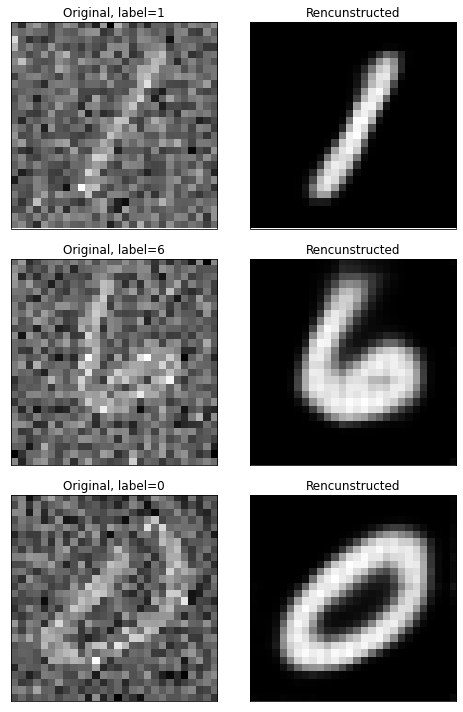

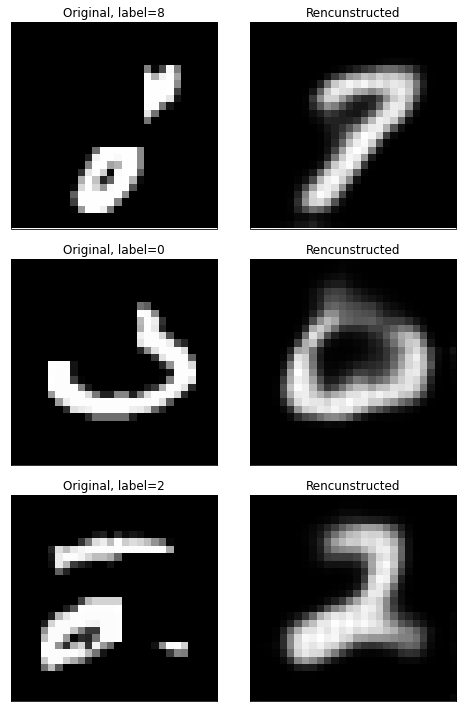

In [ ]:
#!WARNING in this case the loss is computed using the input image as target which is wrong. These lines were only meant for plotting

s = 0.45
p = 0.2

loss_fn = torch.nn.MSELoss()
net = torch.load(path+"Final_model.torch")
net.to(device)

test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=modifier(None))
test_dataset_noise  = MNIST(data_root_dir, train=False, download=True, transform=modifier("noise", mean=0, std=s))
test_dataset_occlude  = MNIST(data_root_dir, train=False, download=True, transform=modifier("occlude", portion=p))

test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
test_dataloader_noise = DataLoader(test_dataset_noise, batch_size=512, shuffle=False)
test_dataloader_occlude = DataLoader(test_dataset_occlude, batch_size=512, shuffle=False)


l, noise, clean = net.test_epoch(test_dataloader_noise, loss_fn, additional_out=True)
fig, ax = plt.subplots(3,2, figsize=(7,10))
for i in range(3):
    idx = idx = np.random.randint(0, noise.shape[0])
    ax[i][1].imshow(noise.squeeze()[idx], cmap='gist_gray')
    ax[i][1].set_title("Rencunstructed")
    ax[i][0].imshow(clean.squeeze()[idx],  cmap='gist_gray')
    ax[i][0].set_title("Original, label="+str(test_dataset[idx][1]))
    ax[i][0].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][1].set_xticks([])
    ax[i][0].set_yticks([])
fig.tight_layout()
fig.savefig(path+"img/recostruction_noise_"+str(s)+".png")

l, occluded, clean_occ = net.test_epoch(test_dataloader_occlude, loss_fn, additional_out=True)
fig, ax = plt.subplots(3,2, figsize=(7,10))
for i in range(3):
    idx = idx = np.random.randint(0, noise.shape[0])
    ax[i][1].imshow(occluded.squeeze()[idx], cmap='gist_gray')
    ax[i][1].set_title("Rencunstructed")
    ax[i][0].imshow(clean_occ.squeeze()[idx],  cmap='gist_gray')
    ax[i][0].set_title("Original, label="+str(test_dataset[idx][1]))
    ax[i][0].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][1].set_xticks([])
    ax[i][0].set_yticks([])
fig.tight_layout()
fig.savefig(path+"img/recostruction_occlusion_"+str(p)+".png")



### Compute loss for different values of the modification 

In [ ]:
compute = False
if compute:
    std = [0.45]
    portion = [0.2]

    loss_noise=[]
    loss_occlude=[]

    loss_fn = torch.nn.MSELoss()
    net = torch.load(path+"Final_model.torch")
    net.to(device)

    #Clean dataset
    test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
    loss = net.test_epoch(test_dataloader,loss_fn)

    for s,p in zip(std,portion):

        test_dataset_noise  = MNIST(data_root_dir, train=False, download=True, transform=modifier("noise",mean=0, std=s))
        test_dataset_occlude  = MNIST(data_root_dir, train=False, download=True, transform=modifier("occlude", portion=p))

        noise_all = create_mod_dataset(test_dataset, test_dataset_noise)
        occlude_all = create_mod_dataset(test_dataset, test_dataset_occlude)

        test_dataloader_noise = DataLoader(noise_all, batch_size=512, shuffle=False)
        test_dataloader_occlude = DataLoader(occlude_all, batch_size=512, shuffle=False)

        loss_noise.append(net.test_epoch_mod(test_dataloader_noise, loss_fn))
        loss_occlude.append(net.test_epoch_mod(test_dataloader_occlude, loss_fn))

        print(loss_noise)
        print(loss_occlude)

    #loss_vs_std = np.hstack((std.reshape(-1,1),np.array(loss_noise).reshape(-1,1)))#,np.array(val_loss_dim_std).reshape(-1,1)))
    #np.savetxt(path+"loss_vs_std.txt", loss_vs_std)
    #loss_vs_portion = np.hstack((portion.reshape(-1,1),np.array(loss_occlude).reshape(-1,1)))#,np.array(val_loss_dim_std).reshape(-1,1)))
    #np.savetxt(path+"loss_vs_portion.txt", loss_vs_portion )
else:
    print("Flag is set to FALSE so nothing happened")
    

[array(0.03395665, dtype=float32)]
[array(0.04993875, dtype=float32)]


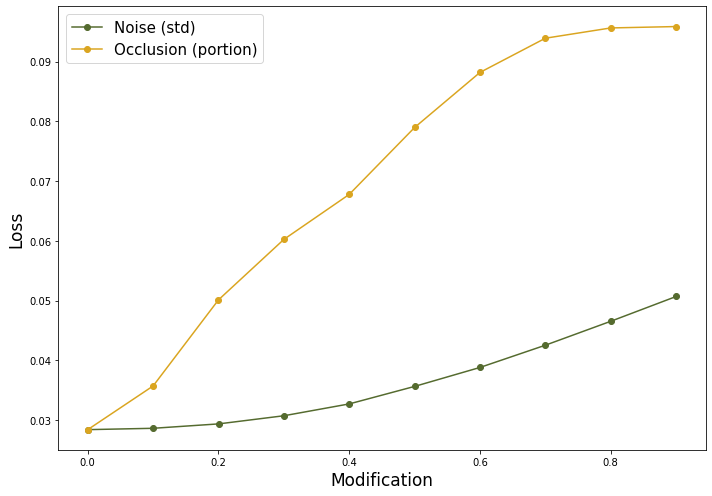

In [ ]:
loss_vs_std=np.loadtxt(path+"loss_vs_std.txt").T
loss_vs_portion=np.loadtxt(path+"loss_vs_portion.txt").T
std=loss_vs_std[0]
loss_noise=loss_vs_std[1]
portion=loss_vs_portion[0]
loss_occlude=loss_vs_portion[1]

#Plot 
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(std, loss_noise, marker=".", markersize=12, color="darkolivegreen", label="Noise (std)")
ax.plot(portion, loss_occlude, marker=".", markersize=12, color="goldenrod", label="Occlusion (portion)")
ax.set_ylabel("Loss", fontsize=17)
ax.set_xlabel("Modification", fontsize=17)
#ax.grid()
ax.legend(fontsize=15)
fig.tight_layout()
fig.savefig(path+"img/loss_vs_mod.png")

# Denoising

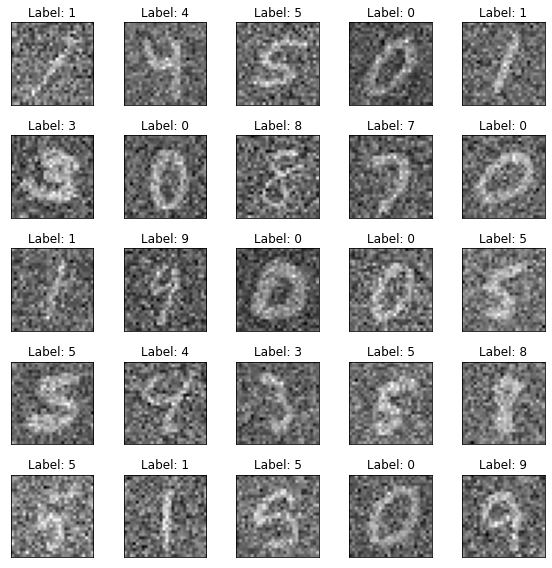

In [ ]:
#Generating datasets for denoising training
train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)

s=0.45
train_dataset_noise  = MNIST(data_root_dir, train=True, download=True, transform=modifier("noise",mean=0, std=s))
test_dataset_noise  = MNIST(data_root_dir, train=False, download=True, transform=modifier("noise",mean=0, std=s))

train_noise = create_mod_dataset(train_dataset, train_dataset_noise)
test_noise = create_mod_dataset(test_dataset, test_dataset_noise)

### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, noised, label = random.choice(test_noise)
    ax.imshow(noised.squeeze().cpu().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

### Training

In [ ]:
denoise_train = False
verbose = True

if denoise_train:

    #Load best hyperparameters
    best_set=pd.read_csv(path+"best_set.csv", sep=",")
    best_set=best_set.drop(["val_loss"], axis=1).to_dict("r")[0]
    dropout = best_set["dropout"]
    lr = best_set["lr"]
    L2decay=best_set["weight_decay"]
    
    #Rest of parameters
    n_folds = 3
    patience = 10
    num_epochs = 100

    encoded_space_dim = 6
    
    #no cross validation is performed but a validation set is used for early stopping
    kfolds = KFold(n_splits=n_folds,random_state=0, shuffle=True)
    kfolds.get_n_splits(train_dataset)
    
        
    for train_index, val_index in kfolds.split(train_dataset):

        #reinitialize the network
        net = Autoencoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
        loss_fn = torch.nn.MSELoss()
        optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2decay)
        net.to(device)

        #divide validation and training set
        train_set = torch.utils.data.Subset(train_noise, train_index)
        val_set = torch.utils.data.Subset(train_noise, val_index)
        #Define dataloader
        train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True)
        val_dataloader = DataLoader(val_set, batch_size=512, shuffle=False)
        test_dataloader = DataLoader(test_noise, batch_size=512, shuffle=False)

        #Train for #epochs with early stopping
        tl, vl = net.train_full(num_epochs, patience, train_dataloader, val_dataloader, loss_fn, optim, verbose, denoise=True)
        #load best model
        net = torch.load(path+'denoise_model_esd_'+str(int(encoded_space_dim))+'.torch')
        #compute test loss over best model
        test_loss = net.test_epoch_mod(test_dataloader, loss_fn)
        #we just train it over one fold
        break
        
    torch.save(net, path+'Final_model_denoise_2.torch')    
    print("Final model in denoise mode has test_loss:", test_loss.round(4))

else:
    
    print("Flag is set to FALSE, nothing happened")




	 VALIDATION - EPOCH 1/100 - loss: 0.111734



 Time elapsed for one epoch: 5.496774911880493


	 VALIDATION - EPOCH 2/100 - loss: 0.069784



 Time elapsed for one epoch: 5.2241644859313965


	 VALIDATION - EPOCH 3/100 - loss: 0.067210



 Time elapsed for one epoch: 5.398896932601929


	 VALIDATION - EPOCH 4/100 - loss: 0.066231



 Time elapsed for one epoch: 5.3795325756073


	 VALIDATION - EPOCH 5/100 - loss: 0.064913



 Time elapsed for one epoch: 5.1432578563690186


	 VALIDATION - EPOCH 6/100 - loss: 0.061913



 Time elapsed for one epoch: 5.265866279602051


	 VALIDATION - EPOCH 7/100 - loss: 0.059820



 Time elapsed for one epoch: 5.385227680206299


	 VALIDATION - EPOCH 8/100 - loss: 0.058586



 Time elapsed for one epoch: 5.204955816268921


	 VALIDATION - EPOCH 9/100 - loss: 0.057110



 Time elapsed for one epoch: 5.12843132019043


	 VALIDATION - EPOCH 10/100 - loss: 0.054213



 Time elapsed for one epoch: 5.8559136390686035


	 VALIDATION - EPOCH 11/100 - loss: 0

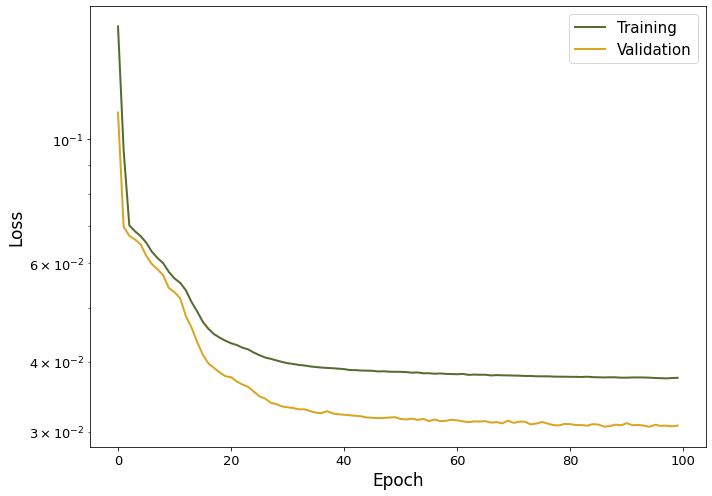

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.semilogy(tl, label="Training", color="darkolivegreen", linewidth=2)
ax.semilogy(vl, label="Validation", color="goldenrod", linewidth=2)
ax.set_ylabel("Loss", fontsize=17)
ax.set_xlabel("Epoch", fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax.legend(fontsize=15)
fig.tight_layout()
fig.savefig(path+"img/final_training_denoise.png")
plt.show()

### Denoising plots

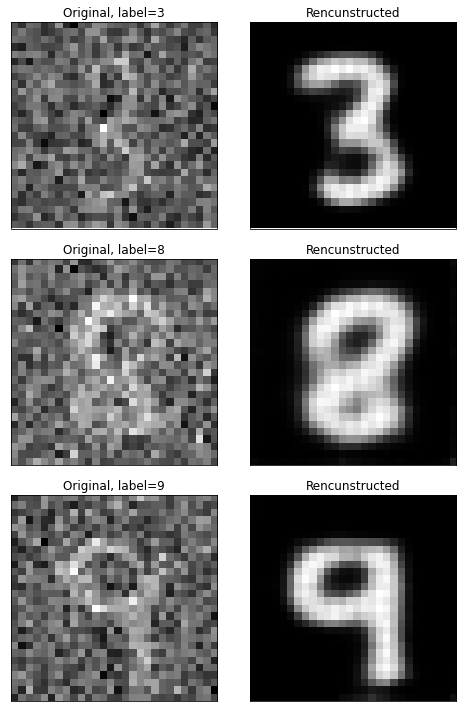

In [ ]:
denoiser = torch.load(path+'Final_model_denoise_2.torch')   
denoiser.to(device)

test_dataset = MNIST(data_root_dir, train=False, download=True, transform=test_transform)
s=0.45
test_dataset_noise = MNIST(data_root_dir, train=False, download=True, transform=modifier("noise",mean=0, std=s))
test_noise = create_mod_dataset(test_dataset, test_dataset_noise)
test_dataloader = DataLoader(test_noise, batch_size=512, shuffle=False)

test_loss, denoised, _ = denoiser.test_epoch_mod(test_dataloader, loss_fn, additional_out=True)

fig, ax = plt.subplots(3,2, figsize=(7,10))
for i in range(3):
    idx = idx = np.random.randint(0, denoised.shape[0])
    ax[i][1].imshow(denoised.squeeze()[idx], cmap='gist_gray')
    ax[i][1].set_title("Rencunstructed")
    ax[i][0].imshow(test_noise[idx][1].squeeze().cpu(),  cmap='gist_gray')
    ax[i][0].set_title("Original, label="+str(test_noise[idx][2]))
    ax[i][0].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][1].set_xticks([])
    ax[i][0].set_yticks([])
fig.tight_layout()
fig.savefig(path+"img/denoising_"+str(s)+".png")


### Compute loss for different values of std (!Network is trained on std=0.45)

In [ ]:
compute_denoise = True

if compute_denoise:

    std = np.arange(0.0001,1,0.1)

    loss_noise=[]

    loss_fn = torch.nn.MSELoss()
    net = torch.load(path+'Final_model_denoise_2.torch')
    net.to(device)

    #Clean dataset
    test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
    loss = net.test_epoch(test_dataloader,loss_fn)

    for s in std:

        test_dataset_noise = MNIST(data_root_dir, train=False, download=True, transform=modifier("noise",mean=0, std=s))
        test_noise = create_mod_dataset(test_dataset, test_dataset_noise)
        test_dataloader_noise = DataLoader(test_noise, batch_size=512, shuffle=False)

        loss_noise.append(net.test_epoch_mod(test_dataloader_noise, loss_fn))

    loss_vs_std = np.hstack((std.reshape(-1,1),np.array(loss_noise).reshape(-1,1)))#,np.array(val_loss_dim_std).reshape(-1,1)))
    np.savetxt(path+"loss_vs_std_denoise_2.txt", loss_vs_std)
else:
    print("Flag is set to False so nothing happened")

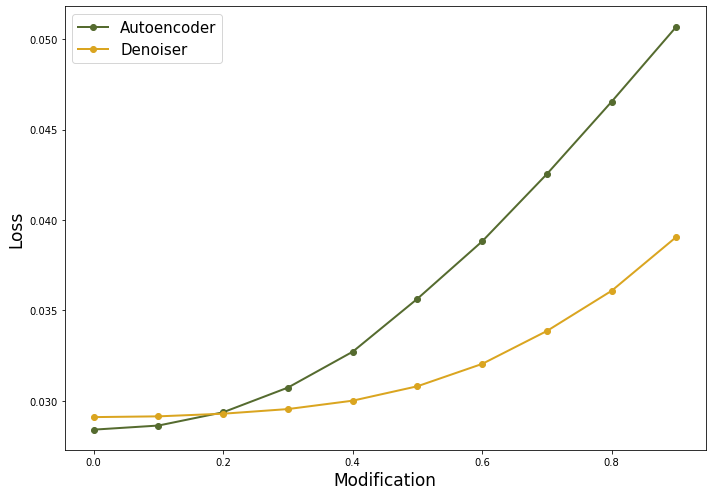

In [ ]:
loss_vs_std=np.loadtxt(path+"loss_vs_std_denoise_2.txt").T
std_denoise=loss_vs_std[0]
loss_noise_denoise=loss_vs_std[1]
loss_vs_std=np.loadtxt(path+"loss_vs_std.txt").T
std=loss_vs_std[0]
loss_noise=loss_vs_std[1]

#Plot 
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(std, loss_noise, marker=".", markersize=12, color="darkolivegreen", label="Autoencoder", linewidth=2)
ax.plot(std_denoise, loss_noise_denoise, marker=".", markersize=12, color="goldenrod", label="Denoiser", linewidth=2)
#semilogax.plot(portion, loss_occlude, marker=".", markersize=12, color="goldenrod", label="Occlusion (portion)")
ax.set_ylabel("Loss", fontsize=17)
ax.set_xlabel("Modification", fontsize=17)
#ax.grid()
ax.legend(fontsize=15)
fig.tight_layout()
fig.savefig(path+"img/loss_vs_std_both_2.png")

# Exploring the encoded space

### Visualization

In [ ]:
from sklearn.decomposition import PCA

compute=False
if compute: 
    net = torch.load(path+"Final_model.torch")
    net.to(device)
    #encoding test samples
    encoded_samples, labels = net.get_encoded(test_dataset)
    encoded_samples=np.array(encoded_samples)
    
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    pca = PCA(n_components=2)
    #performing PCA
    print("PCA")
    encoded_space_pca = pca.fit_transform(encoded_samples)
    #performing t-SNE
    print("t_SNE")
    encoded_space_tsne = tsne.fit_transform(encoded_samples)
    #saving
    print("Saving...")
    np.save(path+"encoded_test_tsne.npy", encoded_space_tsne)
    np.save(path+"encoded_test_pca.npy", encoded_space_pca)
else:
    print("Flag is set to FALSE so nothing happened")

100%|██████████| 10000/10000 [00:06<00:00, 1438.87it/s]


PCA
t_SNE
Saving...


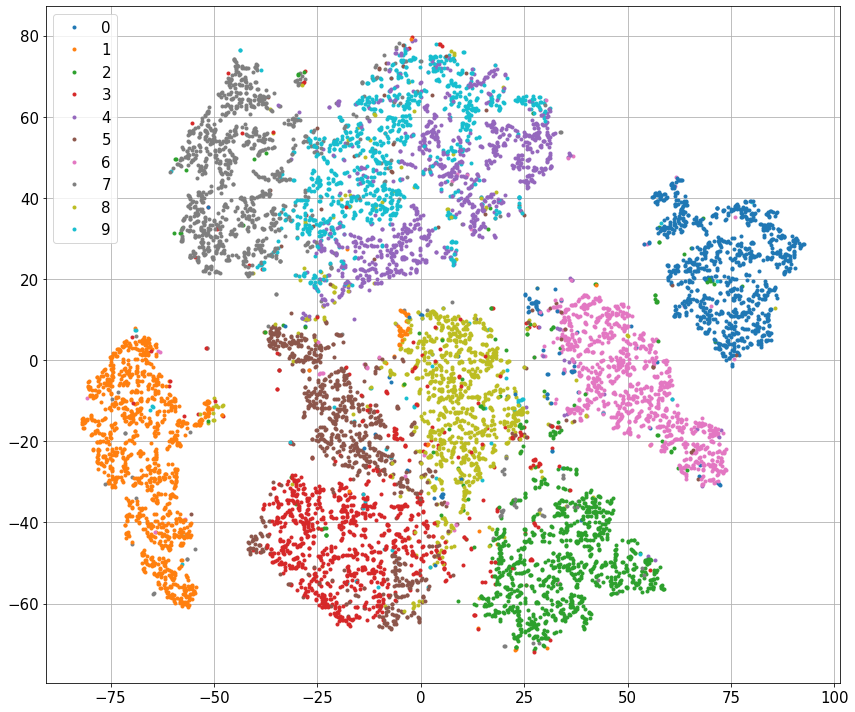

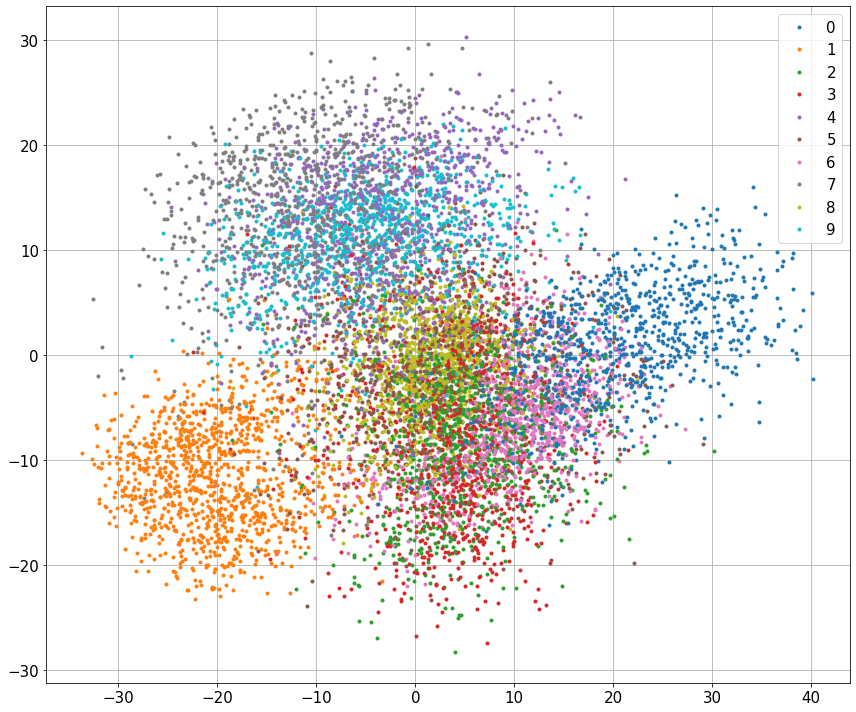

In [ ]:
encoded_space_tsne=np.load(path+"encoded_test_tsne.npy")
encoded_space_pca=np.load(path+"encoded_test_pca.npy")

### Visualize encoded space
color_map = {
        0: '#1f77b4',
        1: '#ff7f0e',
        2: '#2ca02c',
        3: '#d62728',
        4: '#9467bd',
        5: '#8c564b',
        6: '#e377c2',
        7: '#7f7f7f',
        8: '#bcbd22',
        9: '#17becf'
        }
plt.figure(figsize=(12,10))
for enc_sample, label in zip(encoded_space_tsne, labels):
    plt.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
plt.grid(True)
plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys(), fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tight_layout()
plt.savefig(path+"img/AE_tSNE.png")
plt.show()

plt.figure(figsize=(12,10))
for enc_sample, label in zip(encoded_space_pca, labels):
    plt.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
plt.grid(True)
plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys(), fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tight_layout()
plt.savefig(path+"img/AE_PCA.png")
plt.show()

### Morphing



  0%|          | 0/982 [00:00<?, ?it/s]

 21%|██        | 203/982 [00:00<00:00, 2029.25it/s]

 40%|███▉      | 389/982 [00:00<00:00, 1972.53it/s]

 58%|█████▊    | 565/982 [00:00<00:00, 1903.32it/s]

 77%|███████▋  | 752/982 [00:00<00:00, 1891.78it/s]

100%|██████████| 982/982 [00:00<00:00, 1849.20it/s]


  0%|          | 0/1009 [00:00<?, ?it/s]

 19%|█▉        | 195/1009 [00:00<00:00, 1944.40it/s]

 37%|███▋      | 377/1009 [00:00<00:00, 1902.89it/s]

 57%|█████▋    | 578/1009 [00:00<00:00, 1931.44it/s]

 77%|███████▋  | 778/1009 [00:00<00:00, 1947.46it/s]

100%|██████████| 1009/1009 [00:00<00:00, 1917.41it/s]


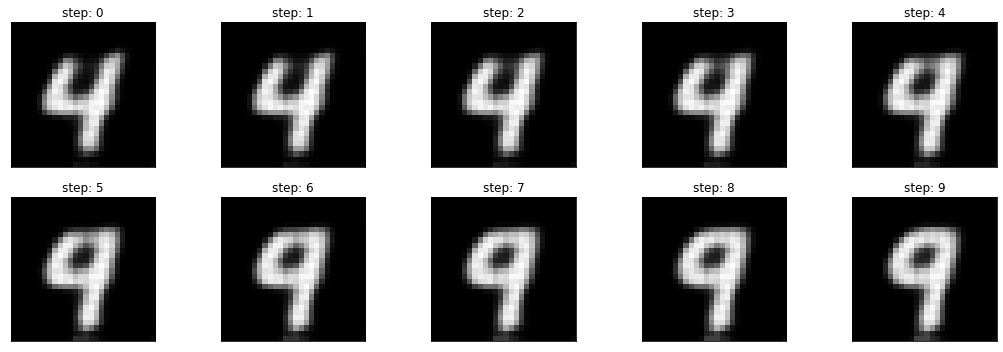

In [ ]:
net = torch.load(path+"Final_model.torch")
net.to(device)
start=4
end=9
filename="space_walk_"+str(start)+"_"+str(end)+".png"
net.encoded_space_walk(test_dataset, start, end, filename, steps=10)